# Trash Data Analysis

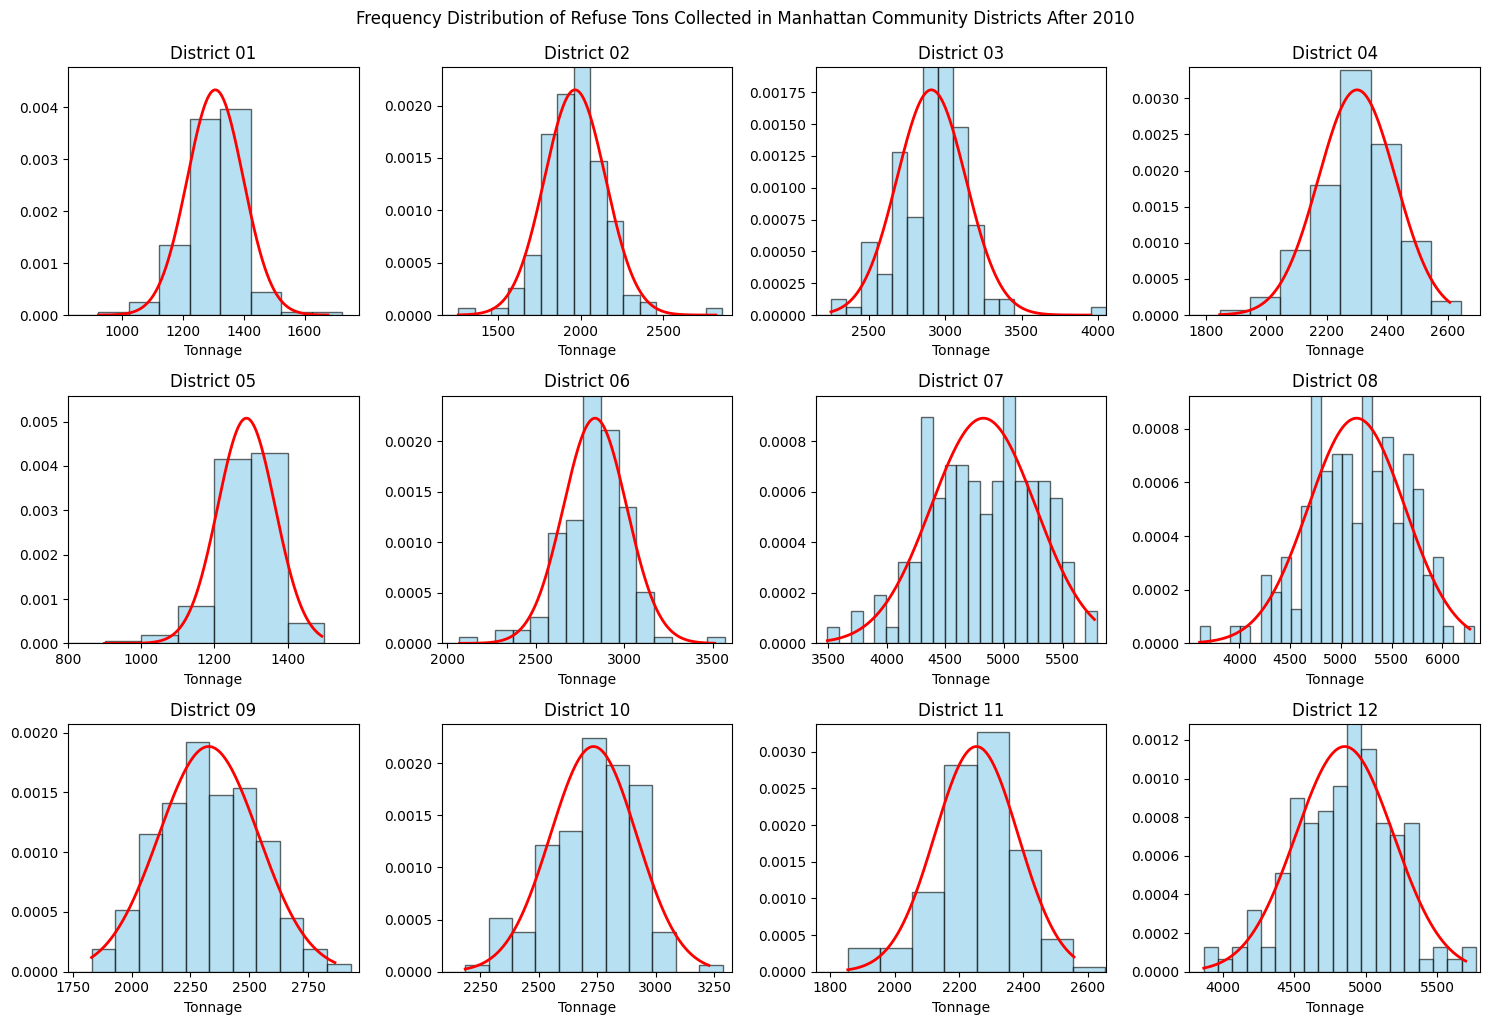

In [122]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

def plot_districts_frequency_with_normal_subplots(df, year, interval_width=10):
    """
    Filters data for all community districts in Manhattan after a given year,
    then plots the frequency distribution of refuse tons collected with specified interval width,
    overlaying a normal distribution curve for each district in individual subplots with unique scales.
    
    Parameters:
    df (pd.DataFrame): The dataframe containing the data.
    year (int): The year threshold; only data after this year will be considered.
    interval_width (int): The width of bins for the histogram, default is 10.
    """
    # Parse the MONTH column using the correct format
    df['MONTH'] = pd.to_datetime(df['MONTH'], format='%Y / %m')

    # Set up a 3x4 grid for 12 subplots
    fig, axes = plt.subplots(3, 4, figsize=(15, 10))
    axes = axes.flatten()  # Flatten to easily iterate through subplots

    # Loop through each community district (1 to 12)
    for district in range(1, 13):
        # Convert the district number to a two-digit string (e.g., '1' -> '01')
        district_str = f"{district:02}"

        # Filter rows by BOROUGH, COMMUNITYDISTRICT, and year
        filtered_df = df[
            (df['BOROUGH'] == 'Manhattan') &
            (df['COMMUNITYDISTRICT'] == district_str) &
            (df['MONTH'].dt.year > year) & 
            # (df['MONTH'].dt.month == 11) &
            (df['MONTH'].dt.year != 2024)
        ]

        # Drop rows with NaN values in REFUSETONSCOLLECTED
        filtered_df = filtered_df.dropna(subset=['REFUSETONSCOLLECTED'])

        # Skip if the filtered dataframe is empty
        if filtered_df.empty:
            print(f"No data available for community district {district_str} after {year}.")
            continue

        # Calculate the mean and standard deviation of the data
        mean = filtered_df['REFUSETONSCOLLECTED'].mean()
        std_dev = filtered_df['REFUSETONSCOLLECTED'].std()

        # Set up the current subplot
        ax = axes[district - 1]
        
        # Calculate appropriate bins for each district individually
        min_tonnage = int(filtered_df['REFUSETONSCOLLECTED'].min())
        max_tonnage = int(filtered_df['REFUSETONSCOLLECTED'].max())
        bins = range(min_tonnage - interval_width, max_tonnage + interval_width, interval_width)

        # Plot the histogram for the district
        ax.hist(filtered_df['REFUSETONSCOLLECTED'], bins=bins, edgecolor='black', density=True, alpha=0.6, color='skyblue')

        # Generate x values for the normal distribution curve
        x_values = np.linspace(min_tonnage, max_tonnage, 1000)
        normal_curve = norm.pdf(x_values, mean, std_dev)

        # Plot the normal distribution curve
        ax.plot(x_values, normal_curve, color='red', linestyle='-', linewidth=2)

        # Set individual scales for each district
        ax.set_xlim(min_tonnage - interval_width, max_tonnage + interval_width)
        ax.set_ylim(0, normal_curve.max() * 1.1)  # Scale y-axis based on max density

        # Add titles and labels
        ax.set_title(f'District {district_str}')
        ax.set_xlabel('Tonnage')
        #ax.set_ylabel('Density')

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.suptitle(f'Frequency Distribution of Refuse Tons Collected in Manhattan Community Districts After {year}', y=1.02)
    plt.show()

# Example usage
df = pd.read_csv('Tonnage.csv')
plot_districts_frequency_with_normal_subplots(df, year=2010, interval_width=100)

In [114]:
import pandas as pd
import numpy as np
import pickle

def calculate_and_save_stats(df, year):
    """
    Calculates the mean and standard deviation of refuse tons collected for each
    community district in Manhattan after a specified year, then saves these values
    as two separate pickle files.
    
    Parameters:
    df (pd.DataFrame): The dataframe containing the data.
    year (int): The year threshold; only data after this year will be considered.
    """
    # Parse the MONTH column using the correct format
    df['MONTH'] = pd.to_datetime(df['MONTH'], format='%Y / %m')

    # Lists to store mean and standard deviation for each district
    means = []
    std_devs = []

    # Loop through each community district (1 to 12)
    for district in range(1, 13):
        # Convert the district number to a two-digit string (e.g., '1' -> '01')
        district_str = f"{district:02}"

        # Filter rows by BOROUGH, COMMUNITYDISTRICT, and year
        filtered_df = df[
            (df['BOROUGH'] == 'Manhattan') &
            (df['COMMUNITYDISTRICT'] == district_str) &
            (df['MONTH'].dt.year > year) & 
            (df['MONTH'].dt.year != 2024)
        ]

        # Drop rows with NaN values in REFUSETONSCOLLECTED
        filtered_df = filtered_df.dropna(subset=['REFUSETONSCOLLECTED'])

        # Calculate mean and standard deviation for the district, handling empty data
        if not filtered_df.empty:
            mean = filtered_df['REFUSETONSCOLLECTED'].mean()
            std_dev = filtered_df['REFUSETONSCOLLECTED'].std()
        else:
            mean = np.nan
            std_dev = np.nan

        # Append to the lists
        means.append(mean)
        std_devs.append(std_dev)

    # Convert lists to numpy arrays
    means_array = np.array(means)
    std_devs_array = np.array(std_devs)

    # Save the arrays to pickle files
    with open('means.pkl', 'wb') as f:
        pickle.dump(means_array / 30, f)

    with open('std_devs.pkl', 'wb') as f:
        pickle.dump(std_devs_array / np.sqrt(30), f)

    print(means_array / 30)
    print(std_devs_array / np.sqrt(30))
    print("Means and standard deviations saved as 'means.pkl' and 'std_devs.pkl'.")

# Example usage
df = pd.read_csv('Tonnage.csv')
calculate_and_save_stats(df, year=2010)


[ 43.57303419  65.53205128  96.98660256  76.66292735  42.92226496
  94.48630342 160.81747863 171.82707265  77.58852564  91.11824786
  75.12809829 161.76136752]
[16.79838579 33.87080644 41.16736255 23.36984624 14.35114892 32.69423326
 81.69584655 86.80051056 38.68093227 33.70994432 23.71098417 62.48376105]
Means and standard deviations saved as 'means.pkl' and 'std_devs.pkl'.


# Rat Data Cleaning

In [3]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

# Load the district shapefile for Manhattan (adjust path as necessary)
ny_districts = gpd.read_file("new/ny.shp")

# Filter for Manhattan districts MN01 through MN12
filtered_districts = ny_districts[ny_districts['district'].isin(
    ['MN01', 'MN02', 'MN03', 'MN04', 'MN05', 'MN06', 'MN07', 'MN08', 'MN09', 'MN10', 'MN11', 'MN12'])]

# Load Tonnage data
tonnage_data = pd.read_csv("Tonnage.csv")

# Convert MONTH to datetime to extract the year, filter for Manhattan and years after 2010
tonnage_data['YEAR'] = pd.to_datetime(tonnage_data['MONTH'], format='%Y / %m').dt.year
tonnage_data = tonnage_data[(tonnage_data['BOROUGH'] == 'Manhattan') & (tonnage_data['YEAR'] > 2010)]

# Group by COMMUNITYDISTRICT and YEAR, summing REFUSETONSCOLLECTED
annual_tonnage = tonnage_data.groupby(['COMMUNITYDISTRICT', 'YEAR'])['REFUSETONSCOLLECTED'].sum().reset_index()
annual_tonnage.rename(columns={'COMMUNITYDISTRICT': 'District', 'REFUSETONSCOLLECTED': 'Annual_Tonnage'}, inplace=True)

# Load Rat Incident Data
rat_data = pd.read_csv("ratheatmap.csv")

# Convert Latitude and Longitude to Point geometries and create a GeoDataFrame
rat_data['geometry'] = rat_data.apply(lambda row: Point(row['Longitude'], row['Latitude']), axis=1)
rat_gdf = gpd.GeoDataFrame(rat_data, geometry='geometry', crs="EPSG:4326")

# Convert rat data to the same CRS as the district shapefile (if necessary)
rat_gdf = rat_gdf.to_crs(filtered_districts.crs)

# Spatial join to assign each rat report to the district it falls within
rat_with_districts = gpd.sjoin(rat_gdf, filtered_districts, predicate='within')

# Extract district information from the 'district' column
rat_with_districts['District'] = rat_with_districts['district'].str.extract(r'(\d+)').astype(int)

# Filter data for years after 2010 and group by District and YEAR
rat_with_districts['YEAR'] = pd.to_datetime(rat_with_districts['Created Date'], errors='coerce').dt.year
rat_reports_by_year = rat_with_districts[rat_with_districts['YEAR'] > 2010]
annual_rat_reports = rat_reports_by_year.groupby(['District', 'YEAR']).size().reset_index(name='Rat_Reports')

# Ensure 'District' columns are of the same data type before merging
annual_tonnage['District'] = annual_tonnage['District'].astype(int)
annual_rat_reports['District'] = annual_rat_reports['District'].astype(int)

# Merge rat reports with the tonnage data
combined_data = pd.merge(annual_tonnage, annual_rat_reports, on=['District', 'YEAR'], how='outer').fillna(0)

# Display the combined result
print(combined_data)

combined_data.to_csv("annual_trash_tonnage_rat_reports.csv", index=False)
print("Data saved to 'annual_trash_tonnage_rat_reports.csv'")

/var/folders/ql/dklml2ln7dnf6l874y2q745w0000gn/T/ipykernel_28881/1650221377.py:24: DtypeWarning: Columns (17,20) have mixed types. Specify dtype option on import or set low_memory=False.
  rat_data = pd.read_csv("ratheatmap.csv")
/var/folders/ql/dklml2ln7dnf6l874y2q745w0000gn/T/ipykernel_28881/1650221377.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  rat_with_districts['YEAR'] = pd.to_datetime(rat_with_districts['Created Date'], errors='coerce').dt.year


     District  YEAR  Annual_Tonnage  Rat_Reports
0           1  2011         14657.0           89
1           1  2012         15018.9           91
2           1  2013         15349.8          115
3           1  2014         15640.1          147
4           1  2015         15670.0          207
..        ...   ...             ...          ...
163        12  2020         59208.0          363
164        12  2021         58106.7          716
165        12  2022         54182.0          672
166        12  2023         53298.3          638
167        12  2024         46290.6          647

[168 rows x 4 columns]
Data saved to 'annual_trash_tonnage_rat_reports.csv'


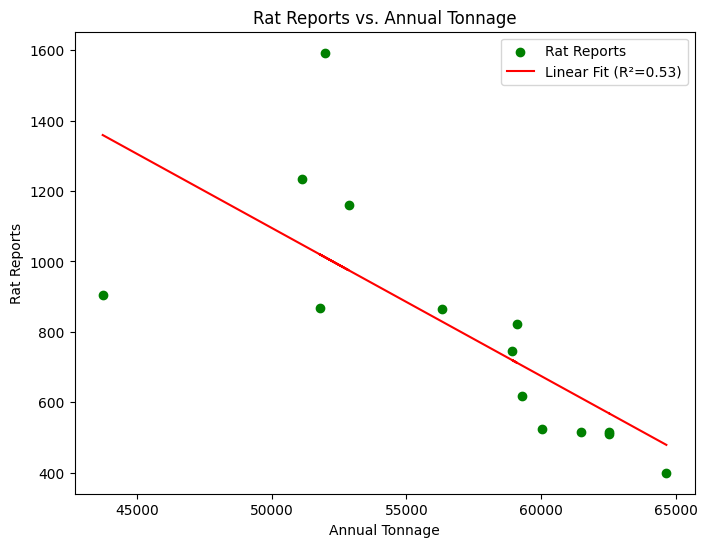

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Load the data
data = pd.read_csv("Trash Tonnage and Rat Reports.csv")

# Filter data for a single district if needed (e.g., District 1)
district_data = data[data['District'] == 7]

# Conduct linear regression with Annual_Tonnage as the independent variable
slope, intercept, r_value, _, _ = linregress(district_data['Annual_Tonnage'], district_data['Rat_Reports'])
regression_line = slope * district_data['Annual_Tonnage'] + intercept

# Plot Rat Reports vs. Annual Tonnage with regression line
plt.figure(figsize=(8, 6))
plt.scatter(district_data['Annual_Tonnage'], district_data['Rat_Reports'], color='green', label="Rat Reports")
plt.plot(district_data['Annual_Tonnage'], regression_line, color='red', label=f"Linear Fit (R²={r_value**2:.2f})")
plt.xlabel("Annual Tonnage")
plt.ylabel("Rat Reports")
plt.title("Rat Reports vs. Annual Tonnage")
plt.legend()
plt.show()